In [1]:
!pip3 install torch torchvision

In [0]:
import torch
import torchvision
import torchvision.datasets as tds
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import PIL
from torchvision import transforms

In [0]:
device = torch.device("cuda:0")

In [4]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                           
])

data_train = tds.SVHN('./', 
                       transform = tfs,
                       download=True)

data_test = tds.SVHN('./', 
                      split='test', 
                      transform = tfs,
                      download=True)

In [0]:
batch_size = 64

validation_size = .2

data_size = data_train.data.shape[0]
split = int(np.floor(validation_size * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

Using downloaded and verified file: ./train_32x32.mat


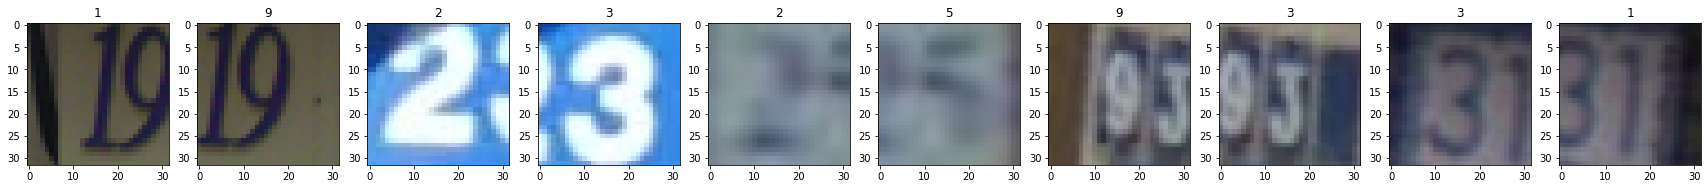

In [6]:
def visualize(data, count=10):
  plt.figure(figsize=(30, 3))
  for i, (X, y) in enumerate(data):
    if i == count:
      break
    plt.subplot(1, 10, i + 1)
    plt.title(y)
    plt.imshow(X)

visualize(tds.SVHN('./', download=True))

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler=None, num_epochs=20):
  train_loss_history = []
  train_history = []
  val_loss_histroy = []
  val_histroy = []

  for i_epoch in range(num_epochs):
    model.train()

    train_loss_sum = 0
    correct_samples = 0
    all_samples = 0

    for i_step, (x, y) in enumerate(train_loader):
      x_gpu = x.to(device)
      y_gpu = y.to(device)
      prediction = model(x_gpu)
      step_loss = loss(prediction, y_gpu)
      optimizer.zero_grad()
      step_loss.backward()
      optimizer.step()

      y_hat = torch.argmax(prediction, 1)
      correct_samples += float(torch.sum(y_hat == y_gpu))
      all_samples += y.shape[0]
      train_loss_sum += step_loss
    
    train_loss = train_loss_sum / i_step
    train_accuracy = correct_samples / all_samples
    val_loss, val_accuracy = compute_accuracy(model, val_loader, loss)
    if scheduler:
      scheduler.step(val_loss)

    train_loss_history.append(train_loss)
    val_loss_histroy.append(val_loss)
    train_history.append(train_accuracy)
    val_histroy.append(val_accuracy)

    print('Epoch num: %f, Train loss: %f, Val loss: %f, Train accuracy: %f, Validation accuracy: %f' % (i_epoch, train_loss, val_loss, train_accuracy, val_accuracy))
  
  return train_loss_history, val_loss, train_history, val_histroy

def compute_accuracy(model, loader, loss):
  model.eval()

  correct_samples = 0
  all_samples = 0
  loss_sum = 0

  for i_step, (x, y) in enumerate(loader):
    x_gpu = x.to(device)
    y_gpu = y.to(device)
    prediction = model(x_gpu)

    loss_sum =+ float(loss(prediction, y_gpu))

    y_hat = torch.argmax(prediction, 1)
    correct_samples += float(torch.sum(y_hat == y_gpu))
    all_samples += y.shape[0]
    
  avg_loss = loss_sum / (i_step + 1)
  accuracy = correct_samples / all_samples

  return avg_loss, accuracy

In [0]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        new_x = x.view(batch_size, -1)
        return new_x

In [0]:
model = nn.Sequential(
          nn.Conv2d(3, 16, 5, padding=2),
          nn.BatchNorm2d(16),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(2),
          nn.Conv2d(16, 32, 3),
          nn.BatchNorm2d(32),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(2),
          nn.Conv2d(32, 64, 3),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(2),
          Flattener(),
          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(inplace=True),
          nn.Linear(128, 10)
)

model.type(torch.cuda.FloatTensor)
model.to(device)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

In [0]:
train_loss_history, val_loss, train_history, val_histroy = train_model(model, train_loader, val_loader, loss, optimizer, scheduler, 30)

Epoch num: 0.000000, Train loss: 1.124793, Val loss: 0.000768, Train accuracy: 0.647942, Validation accuracy: 0.800396
Epoch num: 1.000000, Train loss: 0.580111, Val loss: 0.000640, Train accuracy: 0.821787, Validation accuracy: 0.839880
Epoch num: 2.000000, Train loss: 0.466333, Val loss: 0.000525, Train accuracy: 0.854959, Validation accuracy: 0.842439
Epoch num: 3.000000, Train loss: 0.425770, Val loss: 0.000178, Train accuracy: 0.867245, Validation accuracy: 0.863683
Epoch num: 4.000000, Train loss: 0.378799, Val loss: 0.000475, Train accuracy: 0.879735, Validation accuracy: 0.863188
Epoch num: 5.000000, Train loss: 0.343167, Val loss: 0.000361, Train accuracy: 0.893181, Validation accuracy: 0.870013
Epoch num: 6.000000, Train loss: 0.315628, Val loss: 0.000506, Train accuracy: 0.900280, Validation accuracy: 0.866959
Epoch num: 7.000000, Train loss: 0.260235, Val loss: 0.000543, Train accuracy: 0.920551, Validation accuracy: 0.880268
Epoch num: 8.000000, Train loss: 0.238898, Val l

In [0]:
test_loader = torch.utils.data.DataLoader(data_test)
_, test_accuracy = compute_accuracy(model, test_loader, loss)
print('Test accuracy: %f' % (test_accuracy))